# Burger's Equation in 1D

Here we explore numerical solutions to Burger's equation equation in 1D

\begin{align}
  \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}
  = \nu\frac{\partial^2 u}{\partial x^2}
\end{align}

where $u = u(x,t)$, and $\nu$ is taken here to be a constant. Note that this equation has an advective term as in the non-linear advection equation, and it also has a diffusive term as in the diffusion equation.  

Treating each term as we have done previously gives

\begin{align}
  \frac{u^{n+1}_{i} - u^{n}_{i}}{\Delta{t}}
  + u^{n}_{i}\frac{u^{n}_{i} - u^{n}_{i-1}}{\Delta{x}}
  = \nu\frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}}{(\Delta{x})^2}
\end{align}

which after re-arranging becomes

\begin{align}
  u^{n+1}_{i} = u^{n}_{i}
  - u^{n}_{i}\frac{\Delta{t}}{\Delta{x}}\left(u^{n}_{i} - u^{n}_{i-1}\right)
  + \frac{\nu\Delta{t}}{(\Delta{x})^2}\left(u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}\right)
\end{align}

### Initial conditions

\begin{align}
  u(x,0) = -\frac{2\nu}{\phi_{0}}\frac{\partial\phi_{0}}{\partial x} + 4
\end{align}

where 

\begin{align}
  \phi_{0}(x) = \phi(x,0) = \exp\left(\frac{-x^2}{4\nu}\right) 
  + \exp\left(\frac{-(x-2\pi)^2}{4\nu}\right)
\end{align}

### Boundary conditions

We will look for solutions that satisfy periodic boundary conditions

\begin{align}
  u(0,t) = u(2\pi,t)
\end{align}

### Exact solution

The exact analytical solution to this problem is 

\begin{align}
  u(x,t) = -\frac{2\nu}{\phi}\frac{\partial\phi}{\partial x} + 4
\end{align}

where 

\begin{align}
  \phi(x,t) = \exp\left(\frac{-(x-4t)^2}{4\nu(t+1)}\right) 
  + \exp\left(\frac{-(x-4t-2\pi)^2}{4\nu(t+1)}\right)
\end{align}

In [28]:
import numpy as np
import sympy as sym
%matplotlib notebook
import matplotlib.pyplot as plt

In [29]:
from sympy import init_printing
#init_printing(use_latex=True)
init_printing()

In [30]:
# create symbolic expression for phi(x,t)
x, nu, t = sym.symbols('x nu t')
phi = (sym.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sym.exp(-(x - 4 * t - 2 * np.pi)**2 / (4 * nu * (t + 1))))

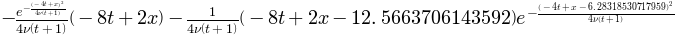

In [31]:
# take a partial derivative of phi(x,t) with respect to x
phiprime = phi.diff(x)
phiprime

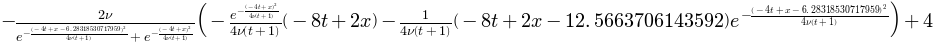

In [32]:
# create symbolic expression for u(x,t)
u = -2 * nu * (phiprime / phi) + 4
u

In [33]:
# lambdify u, in order to allow numeric evaluations
from sympy.utilities.lambdify import lambdify
ufunc = lambdify((t, x, nu), u)
ufunc(1, 4, 3) # sample numeric evaluation

In [34]:
# sample grid function for u
tmin = 0; tmax = 10; tstep = 1; ntsteps = tmax/tstep;
xmin = 0; xmax = 10; xstep = 1; nxsteps = xmax/xstep;
t = np.linspace(tmin, tmax, ntsteps)
x= np.linspace(xmin, xmax, nxsteps)
np.asarray([[ufunc(t, x, 3) for t in tgrid] for x in xgrid])

NameError: name 'xgrid' is not defined

In [37]:
# function to evolve Burger's equation    
def burger(nx):
    """
    evolve solutions to Burger's equation using FTBS scheme
    
    INPUT
    nx = total number of spatial grid points
    
    OUTPUT
    animated plot of numerical and analytical solution
    """
    # diffusivity
    nu = 0.2
    print('diffusion coefficient is',nu)

    # setup spatial grid (vertex-centered)
    L = 2*np.pi     # size of physical grid
    dx = L/(nx-1)   # grid spacing
    x = np.linspace(0, L, nx)
    print('grid spacing is',dx)

    # setup time grid
    dt = dx*nu   # size of timesteps
    nt = 100     # total number of timesteps
    t = np.linspace(0, (nt-1)*dt, nt+1)
    print('time stepsize is',dt)

    # initialize grid functions
    u = np.zeros((nt, nx))
    u_exact = np.zeros((nt, nx)) 
    
    # initial data
    t0 = t[0]
    u[0,:] = np.asarray(ufunc(t0, x, nu))
    
    # exact solution
    u_exact = np.asarray([[ufunc(tn, xj, nu) for xj in x] for tn in t])

    # solve
    for n in range(nt-1):
        # update interior points using FTCS scheme
        for i in range (1,nx-1):
            u[n+1,i] = u[n,i] - dt/dx*u[n,i]*(u[n,i] - u[n,i-1]) \
            + nu*dt/dx**2*(u[n,i+1] - 2*u[n,i] + u[n,i-1])
        # update left boundary point using periodic boundary conditions
        u[n+1,0] = u[n,0] - dt/dx*u[n,0]*(u[n,0] - u[n,-2]) \
            + nu*dt/dx**2*(u[n,1] - 2*u[n,0] + u[n,-2])
        # update right boundary point using periodic boundary conditions 
        u[n+1,-1] = u[n,0]
        
        #u[n+1,0] = u[n,0]
        #u[n+1, -1] = u[n,-1]

    # create figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot
    for n in range(nt):
        ax.cla()
        ax.plot(x, u[n,:], 'b-', marker='o', label='numerical')
        ax.plot(x, u_exact[n,:], 'g-', label='analytical')
        ax.set_ylim(0, 1.15*np.amax(u[0,:]))
        ax.set_xlim(0, L)
        ax.set_xlabel('x')
        ax.set_ylabel('u(x,t)')
        ax.legend(loc='upper left')
        ax.set_title('time step = %.2f' % n)
        fig.canvas.draw()

('diffusion coefficient is', 0.2)
('grid spacing is', 0.06283185307179587)
('time stepsize is', 0.012566370614359175)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


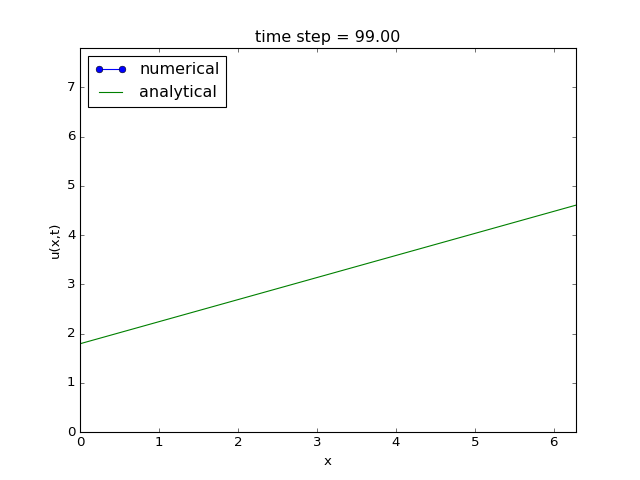

In [38]:
burger(101)